In [280]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
from tqdm.autonotebook import tqdm, trange

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [281]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [3]:
# total_df.tradetime = total_df.close
# total_df.drop(['close', 'pr_close'], 1, inplace = True)
# total_df.rename(columns={'tradetime':'close'}, inplace=True)

/tmp/ipykernel_21193/3316247995.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  total_df.drop(['close', 'pr_close'], 1, inplace = True)


In [291]:
data = total_df[total_df.secid == 'SBER'].drop('secid', 1).close #[['tradedate','close']].set_index('tradedate')

/tmp/ipykernel_20273/627558537.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = total_df[total_df.secid == 'SBER'].drop('secid', 1).close #[['tradedate','close']].set_index('tradedate')


In [283]:
# data_train =   data[:'2022-02-18'].to_numpy()
# data_val = data['2022-05-01':].to_numpy()

# scaler = StandardScaler()
# data_train = scaler.fit_transform(data_train)
# data_val = scaler.transform(data_val)

# print(f'Train shape: {data_train.size}\nVal shape: {data_val.size}')

train_data = data[ : round(data.shape[0]*0.80) ].to_numpy()
train_data1 = data[ : round(data.shape[0]*0.53) ].to_numpy()
train_data2 = data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ].to_numpy()
val_data = data[ round(data.shape[0]*0.80) : ].to_numpy()

scaler = StandardScaler().fit(train_data.reshape(-1,1))
train_data1 = scaler.transform(train_data1.reshape(-1,1))
train_data2 = scaler.transform(train_data2.reshape(-1,1))
val_data = scaler.transform(val_data.reshape(-1,1))

print(f'Train shape: {train_data.size}\nVal shape: {val_data.size}')

Train shape: 6375
Val shape: 1594


In [284]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [299]:
# SEQUENCE_SIZE = 26

# x_train, y_train = to_sequences(SEQUENCE_SIZE, data_train)
# x_val, y_val = to_sequences(SEQUENCE_SIZE, data_val)


# train_dataset = TensorDataset(x_train, y_train)
# val_dataset  = TensorDataset(x_val, y_val)                          


# train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

lookback = 32
horizon = 1

x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([5754, 32, 1]), y_train: torch.Size([5754, 1])
x_val: torch.Size([1562, 32, 1]), y_val: torch.Size([1562, 1])


In [300]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    '''
    input_dim: Token dim(=1 так используем только информацию о цене закрытия)
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    '''
    def __init__(self, input_dim=1, d_model=512, nhead=8, num_layers=5, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.ebedder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.head = nn.Linear(d_model, 1)
    
    def forward(self, x):
        x = self.ebedder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.head(x[:, -1, :])  
        return x    

In [301]:
# def weights_adoptation(path):
#     state_dict = torch.load(path)
#     new_state_dict = {}
#     for key in state_dict:
#         new_key = key.replace('module.','')
#         new_state_dict[new_key] = state_dict[key]
#     return new_state_dict

# path = 'WEIGHTS/(512,8,5,0.1)TRANS(ENC)(U)1D|||W=0.4657, VL=0.7030'

# new_weights = weights_adoptation(path)

# model = TransformerModel().to(device)
# model.load_state_dict(new_weights)

In [320]:
model = TransformerModel(input_dim=1, d_model=512, nhead=8, num_layers=1, dropout=0.0).to(device)

In [321]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    if val_loss < 0.0002:
        torch.save(model.state_dict(), f'ВЕСА/(NEW)TRANS(ENC)(U)1D|||W={val_win / len(val_loader)}, VL={val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 25:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/100 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 100,Train Loss: 0.262380 Validation Loss: 0.015448


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 100,Train Loss: 0.013281 Validation Loss: 0.002154


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 100,Train Loss: 0.007406 Validation Loss: 0.001179


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 100,Train Loss: 0.006092 Validation Loss: 0.000544


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 100,Train Loss: 0.005479 Validation Loss: 0.000748


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 100,Train Loss: 0.005141 Validation Loss: 0.000880


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 100,Train Loss: 0.005131 Validation Loss: 0.000393


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 100,Train Loss: 0.005132 Validation Loss: 0.000521


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 100,Train Loss: 0.004327 Validation Loss: 0.001022


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 100,Train Loss: 0.003910 Validation Loss: 0.000378


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 100,Train Loss: 0.004245 Validation Loss: 0.000548


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 100,Train Loss: 0.003757 Validation Loss: 0.001055


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 100,Train Loss: 0.003734 Validation Loss: 0.001692


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 1.5000e-04.
Epoch 14 / 100,Train Loss: 0.003621 Validation Loss: 0.002082


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 100,Train Loss: 0.003217 Validation Loss: 0.002055


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 100,Train Loss: 0.003388 Validation Loss: 0.000521


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 100,Train Loss: 0.003200 Validation Loss: 0.003151


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 7.5000e-05.
Epoch 18 / 100,Train Loss: 0.003342 Validation Loss: 0.001004


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 100,Train Loss: 0.003063 Validation Loss: 0.000608


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 100,Train Loss: 0.002906 Validation Loss: 0.000684


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 100,Train Loss: 0.002817 Validation Loss: 0.000264


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 100,Train Loss: 0.002954 Validation Loss: 0.000415


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 100,Train Loss: 0.002941 Validation Loss: 0.000731


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 100,Train Loss: 0.002990 Validation Loss: 0.000472


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 3.7500e-05.
Epoch 25 / 100,Train Loss: 0.002760 Validation Loss: 0.000368


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 100,Train Loss: 0.002780 Validation Loss: 0.000926


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 100,Train Loss: 0.002799 Validation Loss: 0.000755


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 100,Train Loss: 0.002733 Validation Loss: 0.000563


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 1.8750e-05.
Epoch 29 / 100,Train Loss: 0.002758 Validation Loss: 0.000944


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 / 100,Train Loss: 0.002710 Validation Loss: 0.000545


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 100,Train Loss: 0.002756 Validation Loss: 0.000636


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 100,Train Loss: 0.002697 Validation Loss: 0.000466


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 9.3750e-06.
Epoch 33 / 100,Train Loss: 0.002629 Validation Loss: 0.000399


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 / 100,Train Loss: 0.002716 Validation Loss: 0.000619


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 100,Train Loss: 0.002636 Validation Loss: 0.000484


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 100,Train Loss: 0.002685 Validation Loss: 0.000796


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 4.6875e-06.
Epoch 37 / 100,Train Loss: 0.002707 Validation Loss: 0.000619


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 / 100,Train Loss: 0.002734 Validation Loss: 0.000458


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 100,Train Loss: 0.002704 Validation Loss: 0.000550


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 100,Train Loss: 0.002736 Validation Loss: 0.000588


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00041: reducing learning rate of group 0 to 2.3437e-06.
Epoch 41 / 100,Train Loss: 0.002657 Validation Loss: 0.000617


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42 / 100,Train Loss: 0.002667 Validation Loss: 0.000509


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 / 100,Train Loss: 0.002557 Validation Loss: 0.000549


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 / 100,Train Loss: 0.002580 Validation Loss: 0.000527


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00045: reducing learning rate of group 0 to 1.1719e-06.
Epoch 45 / 100,Train Loss: 0.002598 Validation Loss: 0.000538


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Early stopping!
Training complete in 0m 40s


In [ ]:
# model = TransformerModel().to(device)
# model.load_state_dict(torch.load('ВЕСА/TRANS(ENC)(U)1D|||W=0.4599, VL=0.0002455'))

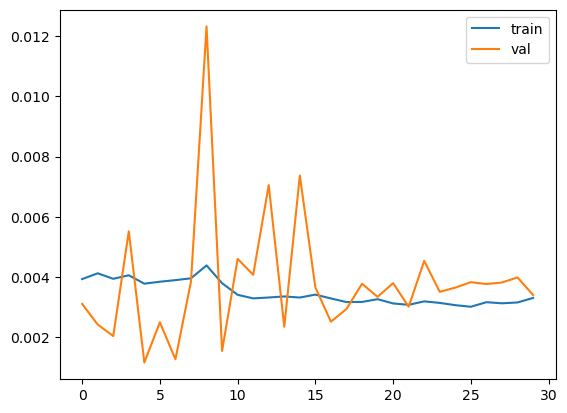

In [314]:
plt.plot(train_loss_per_epoch[2:])
plt.plot(val_loss_per_epoch[2:])
plt.legend(['train','val'])

In [315]:
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)        

In [316]:
winrate( y_val.reshape(-1,), predictions1.reshape(-1,) )

0.44714926329276106

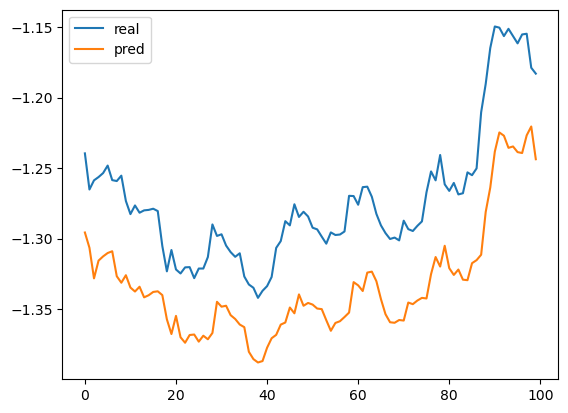

In [317]:
plt.plot(y_val[:100])
plt.plot(predictions1[:100])
plt.legend(['real','pred'])

In [231]:
predictions1 = scaler.inverse_transform(predictions1.reshape(-1,1))
y_val = scaler.inverse_transform(y_val)

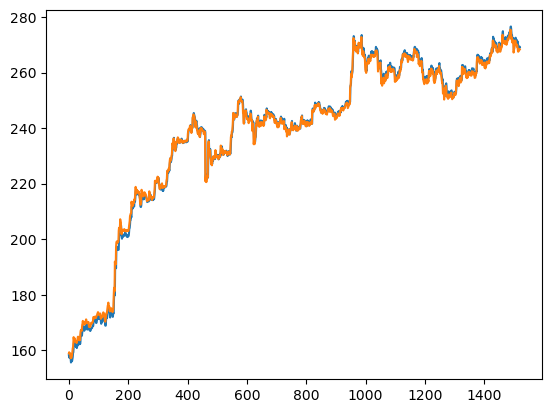

In [232]:
plt.plot(predictions1)
plt.plot(y_val)

In [233]:
criterion(torch.Tensor(y_val),torch.Tensor(predictions1)).item()

2.247159004211426

In [234]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [235]:
winrate(y_train.reshape(-1,), predictions2)

0.47118104667609617

In [236]:
y_train = scaler.inverse_transform(y_train)

In [237]:
predictions2 = scaler.inverse_transform(predictions2.reshape(-1,1))

In [238]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(5.7756)

In [180]:
torch.save(model.state_dict(), f'ЧВЕСА/[256,4,1,0.0]TRANS(ENC)(U)1D|W=0.4838, TL=4.9090 VL=2.1301' )